In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from PIL import Image
from torchvision import models, transforms

from fooling_model import FoollingModel
from utils import power_method, process_image

In [2]:
MAX_PERTURB_NORM = 0.102 # сеть предобучена на нормированных картинках
                         # на тестовом батче максимальная inf-норма была 2.604
                         # в статье максимальная норма 10 на картинках из чисел [0, 255]
                         # => 10/255*2.604 = 0.102

class_index = json.load(open('imagenet_class_index.json'))
idx2name = {
    int(key): value[1]
    for key, value in class_index.items()
}

imgs_dir = '../imgs'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imagenet_transforms = imagenet_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
imgs = []
for imgname in os.listdir(imgs_dir):
    img = Image.open(os.path.join(imgs_dir, imgname)).convert('RGB')
    imgs.append(imagenet_transforms(img).to(device))
img_batch = torch.stack(imgs)

In [4]:
model = models.vgg16(pretrained=True).to(device)
model.eval()

for layer in model.parameters():
    layer.requires_grad = False

fooling_model = FoollingModel(model.features[:8]).to(device)
fooling_model.eval()
matvec, matvec_T = fooling_model.get_jacobian(img_batch)

In [5]:
%%time
p = float('inf')
q = 10.0

init = torch.rand(3 * 224 * 224, device=device) - 0.5
perturb, s = power_method(init, matvec, matvec_T, float('inf'), 10, max_iter=15)

CPU times: user 3min 8s, sys: 1min 1s, total: 4min 10s
Wall time: 4min 10s


singular value 280.1620178222656
perturbation p-norm 1.0


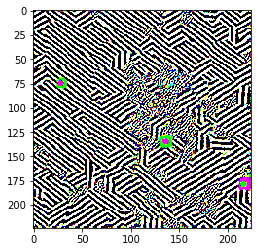

In [6]:
print('singular value', s.item())
print('perturbation p-norm', torch.norm(perturb, p).item()) # если берём p=inf, то всегда будем получать норму 1
normed_perturb = perturb.view(3, 224, 224).cpu() / torch.norm(perturb, p) * MAX_PERTURB_NORM
plt.imshow(process_image(normed_perturb))

In [8]:
orig_output = model(img_batch).cpu()
orig_probs, orig_preds = torch.softmax(orig_output, 1).max(1)

perturbed_output = model(img_batch + normed_perturb.to(device)).cpu()
perturbed_probs, perturbed_preds = torch.softmax(perturbed_output, 1).max(1)

print('rate of changed predictions', (orig_preds != perturbed_preds).float().mean().item())

rate of changed predictions 0.4399999976158142


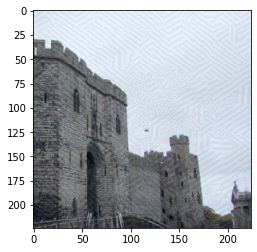

In [7]:
plt.imshow(process_image(img_batch[-1].cpu() + normed_perturb))